# Project Tasks

In the first few assignments, we have learned how to infer part based components (known as mutational signatures) generated by particular mutational processes using Non-negative Matrix Factorization (NMF). By doing this, we are trying to reconstruct the mutation catalog in a given sample with mutational signatures and their contributions.

In this group project, you will use similar mutational profiles and signature activities to predict cancer types but with much larger sample size. 
You should:
* Separate the data into training and test groups within each cancer type.
* Find out which features are informative for the prediction of the cancer type (label). You should combine the profiles and activities and use each data type independently.
* Implement different models for classification of the samples given the input data and evaluate the model performance using test data to avoid overfitting. Explain briefly how does each model that you have used work.
* Report model performance, using standard machine learning metrics such as confusion matrices etc. 
* Compare model performance across methods and across cancer types, are some types easier top predict than others.
* Submit a single Jupyter notebook as the final report and present that during the last assignment session 

# Data

The data include both mutational catalogs from multiple cancers and the predicted activities in the paper ["Alexandrov LB, et al. (2020) The repertoire of mutational signatures in human cancer"](https://www.nature.com/articles/s41586-020-1943-3). The data either are generated from whole human genome (WGS) or only exomes regions (WES). Since the exome region only constitutes about 1% of human genome, the total mutation numbers in these samples are, of course, much smaller. So if you plan to use WGS together with WES data, remember to normalize the profile for each sample to sum up to 1.

Note that, the data is generated from different platforms by different research groups, some of them (e.g. labeled with PCAWG, TCGA) are processed with the same bioinformatics pipeline. Thus, these samples will have less variability related to data processing pipelines.

Cancer types might be labeled under the same tissue, e.g. 'Bone-Benign','Bone-Epith', which can also be combined together or take the one has more samples.

Here is a link to background reading ["Pan-Cancer Analysis of Whole Genomes"](https://www.nature.com/collections/afdejfafdb). Have a look especially the paper ["A deep learning system accurately classifies primary and metastatic cancers using passenger mutation patterns"](https://www.nature.com/articles/s41467-019-13825-8).

In [1]:
import pandas as pd
import re
#import keras

## Mutational catalogs and activities - WGS data

In [2]:
## PCAWG data is performed by the same pipeline
PCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_PCAWG.96.csv")
PCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Accuracy is the cosine similarity of reconstruct catalog to the observed catalog 

In [3]:
## Activities:
PCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_PCAWG.activities.csv")
PCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
nonPCAWG_wgs_mut = pd.read_csv ("./project_data/catalogs/WGS/WGS_Other.96.csv")
nonPCAWG_wgs_mut.head(2)

,Mutation type,Trinucleotide,ALL::PD4020a,ALL::SJBALL011_D,ALL::SJBALL012_D,ALL::SJBALL020013_D1,ALL::SJBALL020422_D1,ALL::SJBALL020579_D1,ALL::SJBALL020589_D1,ALL::SJBALL020625_D1,...,Stomach-AdenoCa::pfg316T,Stomach-AdenoCa::pfg317T,Stomach-AdenoCa::pfg344T,Stomach-AdenoCa::pfg373T,Stomach-AdenoCa::pfg375T,Stomach-AdenoCa::pfg378T,Stomach-AdenoCa::pfg398T,Stomach-AdenoCa::pfg413T,Stomach-AdenoCa::pfg416T,Stomach-AdenoCa::pfg424T
0,C>A,ACA,35,9,2,7,5,7,3,5,...,133,185,202,185,96,134,12,279,75,135
1,C>A,ACC,16,2,4,10,5,9,1,2,...,48,70,126,88,35,54,16,112,31,91


In [5]:
nonPCAWG_wgs_act = pd.read_csv ("./project_data/activities/WGS/WGS_Other.activities.csv")
nonPCAWG_wgs_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0


## Mutational catalogs - WES data

In [11]:
## Performed by TCGA pipeline
TCGA_wes_mut = pd.read_csv ("./project_data/catalogs/WES/WES_TCGA.96.csv")
TCGA_wes_mut.head(2)

,Mutation type,Trinucleotide,AML::TCGA-AB-2802-03B-01W-0728-08,AML::TCGA-AB-2803-03B-01W-0728-08,AML::TCGA-AB-2804-03B-01W-0728-08,AML::TCGA-AB-2805-03B-01W-0728-08,AML::TCGA-AB-2806-03B-01W-0728-08,AML::TCGA-AB-2807-03B-01W-0728-08,AML::TCGA-AB-2808-03B-01W-0728-08,AML::TCGA-AB-2809-03D-01W-0755-09,...,Eye-Melanoma::TCGA-WC-A885-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A888-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-A88A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9A-01A-11D-A39W-08,Eye-Melanoma::TCGA-WC-AA9E-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A980-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A982-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A983-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A984-01A-11D-A39W-08,Eye-Melanoma::TCGA-YZ-A985-01A-11D-A39W-08
0,C>A,ACA,0,0,0,0,4,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,C>A,ACC,0,2,0,0,0,1,3,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
##Activities
TCGA_wes_act = pd.read_csv("./project_data/activities/WES/WES_TCGA.activities.csv")
TCGA_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,AML,TCGA-AB-2802-03B-01W-0728-08,0.811,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AML,TCGA-AB-2803-03B-01W-0728-08,0.608,4,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
other_wes_mut = pd.read_csv("./project_data/catalogs/WES/WES_Other.96.csv")
other_wes_mut.head(2)

,Mutation type,Trinucleotide,ALL::TARGET-10-PAIXPH-03A-01D,ALL::TARGET-10-PAKHZT-03A-01R,ALL::TARGET-10-PAKMVD-09A-01D,ALL::TARGET-10-PAKSWW-03A-01D,ALL::TARGET-10-PALETF-03A-01D,ALL::TARGET-10-PALLSD-09A-01D,ALL::TARGET-10-PAMDKS-03A-01D,ALL::TARGET-10-PAPJIB-04A-01D,...,Head-SCC::V-109,Head-SCC::V-112,Head-SCC::V-116,Head-SCC::V-119,Head-SCC::V-123,Head-SCC::V-124,Head-SCC::V-125,Head-SCC::V-14,Head-SCC::V-29,Head-SCC::V-98
0,C>A,ACA,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
1,C>A,ACC,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
other_wes_act = pd.read_csv("./project_data/activities/WES/WES_Other.activities.csv")
other_wes_act.head(2)

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,TARGET-10-PAIXPH-03A-01D,0.529,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,ALL,TARGET-10-PAKHZT-03A-01R,0.696,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Random forest classifier for mutational catalogue

In [ ]:
#Exploring the datasets...

In [11]:
PCAWG_wgs_mut.head()

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137
2,C>A,ACG,25,13,13,29,8,31,12,15,...,12,29,14,19,51,13,52,14,49,32
3,C>A,ACT,154,70,73,126,31,119,41,122,...,82,213,66,68,271,68,281,80,202,116
4,C>A,CCA,215,63,71,129,30,190,54,133,...,119,188,67,89,307,69,339,204,194,127


In [392]:
#Rotate the the PCAWG_wgs_mut dataset
#Remove rows for "Mutation type" and "Trinucleotide"
#Add a column telling the cancer type of the sample in a row (Used for the labeling in the classifier)
PCAWG_wgs_mutT = PCAWG_wgs_mut.T
PCAWG_wgs_mutT = PCAWG_wgs_mutT.drop(["Mutation type", "Trinucleotide"])
PCAWG_wgs_mutT["type"] = PCAWG_wgs_mutT.index.str.split("::").str[0]
PCAWG_wgs_mutT["tissue"] = PCAWG_wgs_mutT.index.str.split("-").str[0]

In [393]:
PCAWG_wgs_mutT.head(2)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
Biliary-AdenoCA::SP117655,269,148,25,154,215,148,27,180,165,76,...,19,17,43,89,83,48,63,197,Biliary-AdenoCA,Biliary
Biliary-AdenoCA::SP117556,114,56,13,70,63,49,7,69,81,37,...,8,5,20,15,26,10,31,64,Biliary-AdenoCA,Biliary


In [394]:
#Get the number of samples per tumor type
import numpy as np
mutTypes = np.array(PCAWG_wgs_mutT.index.str.split("::").str[0])
unique, counts = np.unique(mutTypes, return_counts=True)
sampCounts = dict(zip(unique, counts))
dict(zip(unique, counts))

{'Biliary-AdenoCA': 35,
 'Bladder-TCC': 23,
 'Bone-Benign': 16,
 'Bone-Epith': 11,
 'Bone-Osteosarc': 38,
 'Breast-AdenoCA': 198,
 'Breast-DCIS': 3,
 'Breast-LobularCA': 13,
 'CNS-GBM': 41,
 'CNS-Medullo': 146,
 'CNS-Oligo': 18,
 'CNS-PiloAstro': 89,
 'Cervix-AdenoCA': 2,
 'Cervix-SCC': 18,
 'ColoRect-AdenoCA': 60,
 'Eso-AdenoCA': 98,
 'Head-SCC': 57,
 'Kidney-ChRCC': 45,
 'Kidney-RCC': 144,
 'Liver-HCC': 326,
 'Lung-AdenoCA': 38,
 'Lung-SCC': 48,
 'Lymph-BNHL': 107,
 'Lymph-CLL': 95,
 'Myeloid-AML': 11,
 'Myeloid-MDS': 4,
 'Myeloid-MPN': 56,
 'Ovary-AdenoCA': 113,
 'Panc-AdenoCA': 241,
 'Panc-Endocrine': 85,
 'Prost-AdenoCA': 286,
 'Skin-Melanoma': 107,
 'SoftTissue-Leiomyo': 15,
 'SoftTissue-Liposarc': 19,
 'Stomach-AdenoCA': 75,
 'Thy-AdenoCA': 48,
 'Uterus-AdenoCA': 51}

In [21]:
#Tissue types and their sample counts
tissueTypes = np.array(PCAWG_wgs_mutT.index.str.split("-").str[0])
unique, counts = np.unique(tissueTypes, return_counts=True)
tissueCounts = dict(zip(unique, counts))
dict(zip(unique, counts))

{'Biliary': 35,
 'Bladder': 23,
 'Bone': 65,
 'Breast': 214,
 'CNS': 294,
 'Cervix': 20,
 'ColoRect': 60,
 'Eso': 98,
 'Head': 57,
 'Kidney': 189,
 'Liver': 326,
 'Lung': 86,
 'Lymph': 202,
 'Myeloid': 71,
 'Ovary': 113,
 'Panc': 326,
 'Prost': 286,
 'Skin': 107,
 'SoftTissue': 34,
 'Stomach': 75,
 'Thy': 48,
 'Uterus': 51}

In [395]:
#Normalising each row so that the mutations sum to 1

PCAWG_wgs_mutTCopy = PCAWG_wgs_mutT.copy(deep=True)
for i in range(len(PCAWG_wgs_mutT)):
    PCAWG_wgs_mutT.iloc[i] = PCAWG_wgs_mutT.iloc[i][:96] / sum(PCAWG_wgs_mutT.iloc[i][:96])
PCAWG_wgs_mutT["type"] = PCAWG_wgs_mutTCopy["type"]
PCAWG_wgs_mutT["tissue"] = PCAWG_wgs_mutTCopy["tissue"]

In [396]:
PCAWG_wgs_mutT.head(2)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
Biliary-AdenoCA::SP117655,0.0180537,0.00993289,0.00167785,0.0103356,0.0144295,0.00993289,0.00181208,0.0120805,0.0110738,0.00510067,...,0.00127517,0.00114094,0.00288591,0.00597315,0.00557047,0.00322148,0.00422819,0.0132215,Biliary-AdenoCA,Biliary
Biliary-AdenoCA::SP117556,0.0224057,0.0110063,0.00255503,0.0137579,0.0123821,0.0096305,0.00137579,0.0135613,0.0159198,0.00727201,...,0.00157233,0.000982704,0.00393082,0.00294811,0.00511006,0.00196541,0.00609277,0.0125786,Biliary-AdenoCA,Biliary


In [336]:
#Random forest classifier for the whole normalised dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

y = PCAWG_wgs_mutT['tissue'] #Labels
X = PCAWG_wgs_mutT.drop(['type', "tissue"], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)


parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}

RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.6561151079136691


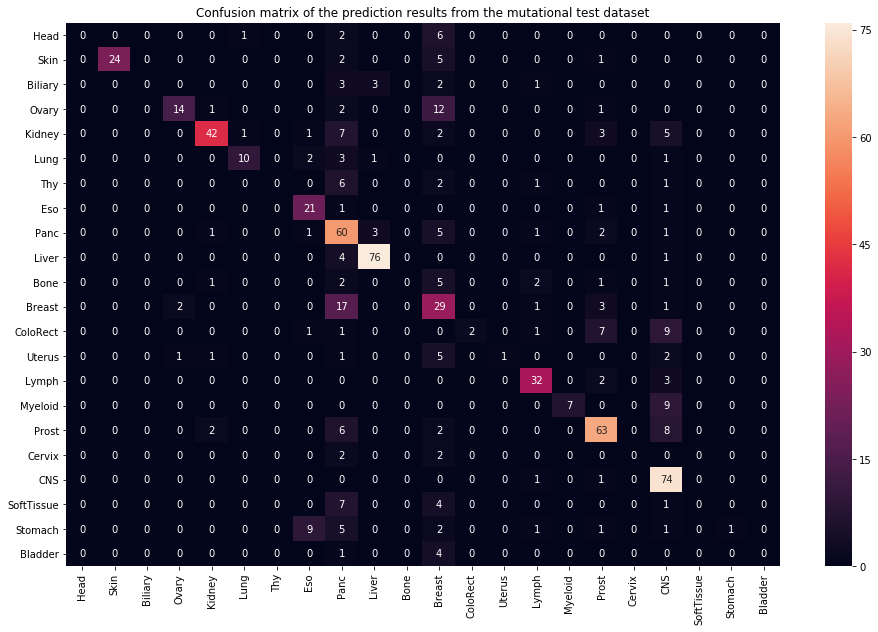

In [341]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the prediction results from the mutational test dataset")
ax = sns.heatmap(confusion, annot=True)
plt.show()

### Validation <a id='Validation'></a>

In [340]:
nonPCAWG_wgs_mutVal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
CNS-GBM::SJHGG001_A,10,3,1,8,4,4,1,3,8,5,...,0,0,1,0,4,1,2,2,CNS-GBM,CNS-GBM
CNS-GBM::SJHGG002_A,30,31,3,22,36,29,18,33,12,7,...,4,2,2,5,3,6,5,11,CNS-GBM,CNS-GBM


In [339]:
#Validation
#Get the cancer types from the nonPCAWG dataset that have matching label to the PCAWG data
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mut.drop(["Mutation type", "Trinucleotide"], axis = 1)

nonPCAWGtissues = list(set(nonPCAWG_wgs_mutVal.columns[61:].str.split("-").str[0]))
PCAWG = list(set(PCAWG_wgs_mut.columns.str.split("::").str[0]))

shared = []
for i in range(len(PCAWG)):
    for j in range(len(nonPCAWG)):
        if nonPCAWG[j] == PCAWG[i]:
            shared.append(nonPCAWG[j])

samplesTokeep = []
for sample in list(nonPCAWG_wgs_mutVal.columns):
    sampleType = sample.split("::")[0]
    if sampleType in shared :
        samplesTokeep.append(sample)  
        
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mutVal[samplesTokeep]
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mutVal.T
nonPCAWG_wgs_mutVal["type"] = nonPCAWG_wgs_mutVal.index.str.split("::").str[0]
nonPCAWG_wgs_mutVal["tissue"] = nonPCAWG_wgs_mutVal.index.str.split("::").str[0]
nonPCAWG_wgs_mutVal.head(2)


,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
CNS-GBM::SJHGG001_A,10,3,1,8,4,4,1,3,8,5,...,0,0,1,0,4,1,2,2,CNS-GBM,CNS-GBM
CNS-GBM::SJHGG002_A,30,31,3,22,36,29,18,33,12,7,...,4,2,2,5,3,6,5,11,CNS-GBM,CNS-GBM


In [163]:
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mut.drop(["Mutation type", "Trinucleotide"], axis = 1)
types = list(nonPCAWG_wgs_mutVal.columns[61:].str.split("::").str[0])
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mutVal.T
nonPCAWG_wgs_mutVal["type"] = nonPCAWG_wgs_mutVal.index.str.split("::").str[0]
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mutVal.iloc[61:]
nonPCAWG_wgs_mutVal["tissue"] = [type.split("-")[0] for type in types]

tissues = PCAWG_wgs_mutT["tissue"].values
indexes = []
for i in range(len(nonPCAWG_wgs_mutVal)):
    if nonPCAWG_wgs_mutVal.iloc[i]["tissue"] in tissues:
        indexes.append(i)
        
nonPCAWG_wgs_mutVal = nonPCAWG_wgs_mutVal.iloc[indexes]

In [338]:
nonPCAWG_wgs_mutVal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
Biliary-AdenoCa::CCA_CH_1,0.018353,0.017046,0.001431,0.018353,0.017606,0.012318,0.001493,0.020157,0.019410,0.011634,...,0.002986,0.002364,0.002862,0.010141,0.011758,0.006532,0.006470,0.016486,Biliary-AdenoCa,Biliary
Biliary-AdenoCa::CCA_CH_2,0.019320,0.009327,0.001999,0.015989,0.009993,0.006662,0.001332,0.014657,0.009327,0.006662,...,0.001999,0.001999,0.001999,0.006662,0.001332,0.001999,0.001332,0.010660,Biliary-AdenoCa,Biliary


In [165]:
#Normalise validation data
nonPCAWG_wgs_mutValCopy = nonPCAWG_wgs_mutVal.copy(deep=True)
for i in range(len(nonPCAWG_wgs_mutVal)):
    nonPCAWG_wgs_mutVal.iloc[i] = nonPCAWG_wgs_mutVal.iloc[i][:96] / sum(nonPCAWG_wgs_mutVal.iloc[i][:96])
nonPCAWG_wgs_mutVal["type"] = nonPCAWG_wgs_mutValCopy["type"]
nonPCAWG_wgs_mutVal["tissue"] = nonPCAWG_wgs_mutValCopy["tissue"]

In [166]:
nonPCAWG_wgs_mutVal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,type,tissue
Biliary-AdenoCa::CCA_CH_1,0.018353,0.017046,0.001431,0.018353,0.017606,0.012318,0.001493,0.020157,0.019410,0.011634,...,0.002986,0.002364,0.002862,0.010141,0.011758,0.006532,0.006470,0.016486,Biliary-AdenoCa,Biliary
Biliary-AdenoCa::CCA_CH_2,0.019320,0.009327,0.001999,0.015989,0.009993,0.006662,0.001332,0.014657,0.009327,0.006662,...,0.001999,0.001999,0.001999,0.006662,0.001332,0.001999,0.001332,0.010660,Biliary-AdenoCa,Biliary


In [332]:
test_y = nonPCAWG_wgs_mutVal["tissue"]
test_X = nonPCAWG_wgs_mutVal.drop(["type", "tissue"], axis = 1)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.5796915167095116


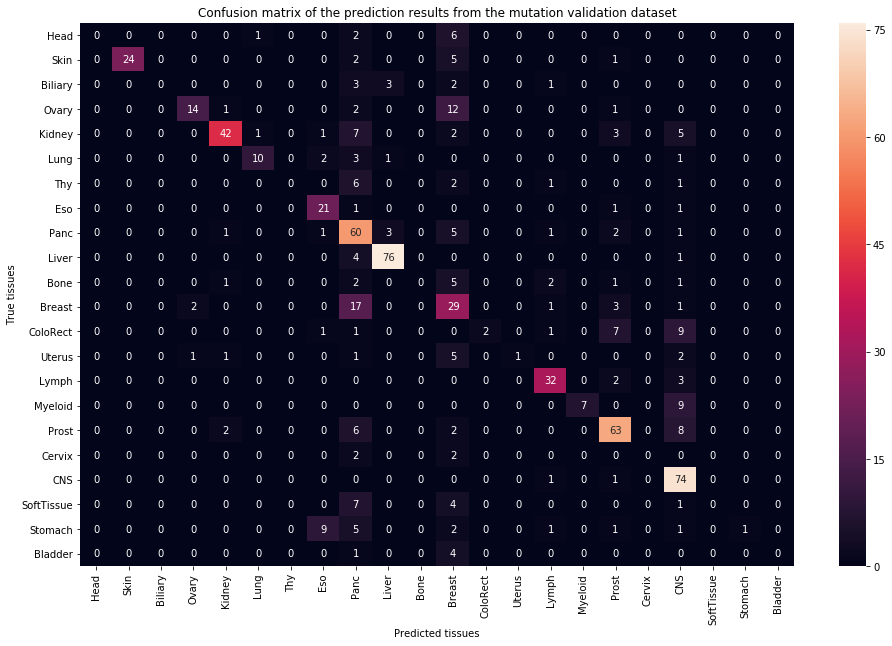

In [342]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the prediction results from the mutation validation dataset")
plt.show()

# Random forest classifier for signature activity data

In [200]:
PCAWG_wgs_act.head()

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biliary-AdenoCA,SP117627,0.973,1110,528,0,0,1453,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Biliary-AdenoCA,SP117775,0.987,1803,1271,0,0,2199,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Biliary-AdenoCA,SP117332,0.987,441,461,0,0,840,0,0,...,0,0,0,0,0,0,0,0,0,0


In [343]:
#Random forest classifier for the whole unmodified signature activity dataset
PCAWG_wgs_actDrop = PCAWG_wgs_act.drop(["Sample Names", "Accuracy"], axis = 1)
y = PCAWG_wgs_actDrop['Cancer Types']
X = PCAWG_wgs_actDrop.drop(['Cancer Types'], axis = 1)# Split the dataset to train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.6230215827338129


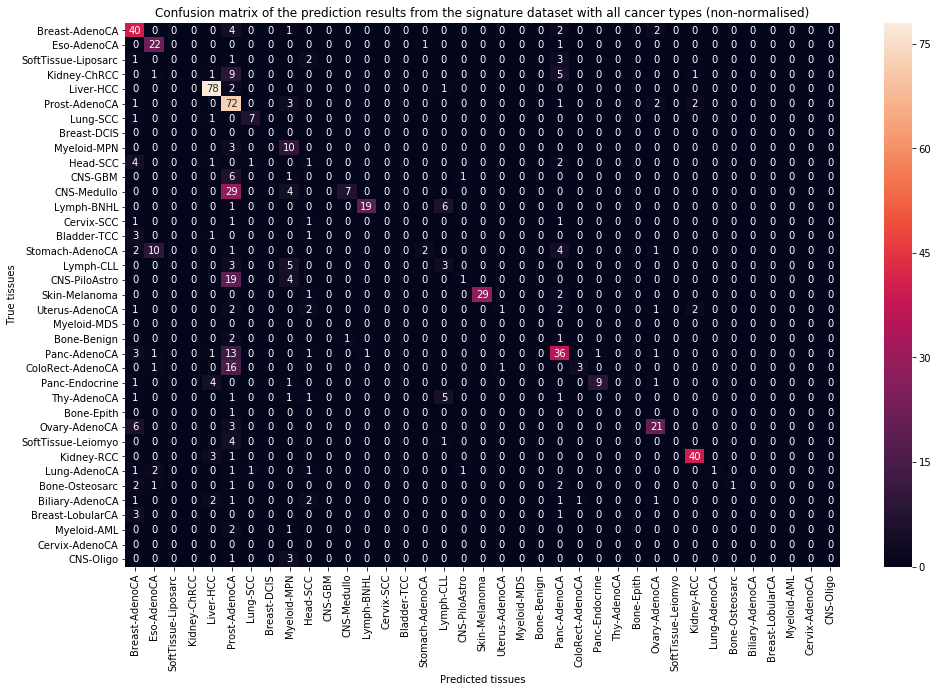

In [349]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the prediction results from the signature dataset with all cancer types (non-normalised)")
plt.show()

In [214]:
#Drop columns "Sample Names" and "Accuracy"
#Normalise the dataset so rows sum to 1
PCAWG_wgs_actNorm = PCAWG_wgs_act.drop(["Sample Names", "Accuracy"], axis = 1)
for i in range(len(PCAWG_wgs_actNorm)):
    PCAWG_wgs_actNorm.iloc[i] = PCAWG_wgs_actNorm.iloc[i][1:] / sum(PCAWG_wgs_actNorm.iloc[i][1:])
PCAWG_wgs_actNorm["Cancer Types"] = PCAWG_wgs_act["Cancer Types"]
tissues = [i.split("-")[0] for i in PCAWG_wgs_actNorm["Cancer Types"]]
PCAWG_wgs_actNorm["tissue"] = tissues

In [215]:
PCAWG_wgs_actNorm.head(2)

,Cancer Types,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,tissue
0,Biliary-AdenoCA,0.100403,0.08698,0.0,0.0,0.122483,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary
1,Biliary-AdenoCA,0.193593,0.00000,0.0,0.0,0.181211,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary


In [355]:
#Random forest classifier for the normalised signature activity dataset (Cancer Types)
y = PCAWG_wgs_actNorm['Cancer Types']
X = PCAWG_wgs_actNorm.drop(['Cancer Types', "tissue"], axis = 1)# Split the dataset to train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.5827338129496403


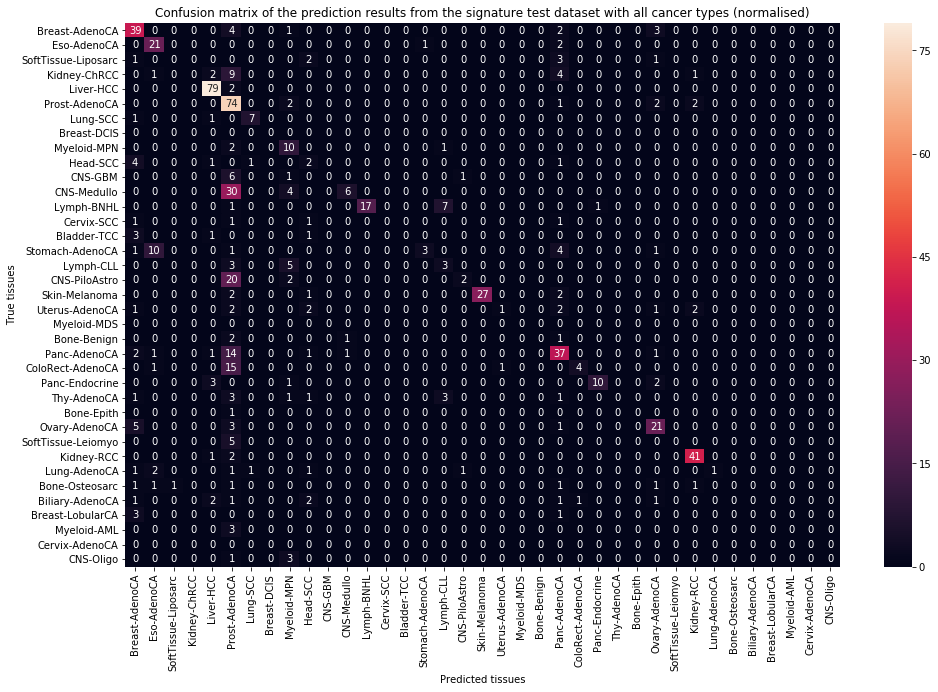

In [356]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the prediction results from the signature test dataset with all cancer types (normalised)")

plt.show()

In [358]:
#Random forest classifier for the normalised signature activity dataset (tissue)
y = PCAWG_wgs_actNorm['tissue'] 
X = PCAWG_wgs_actNorm.drop(['Cancer Types', "tissue"], axis = 1)# Split the dataset to train and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.6230215827338129


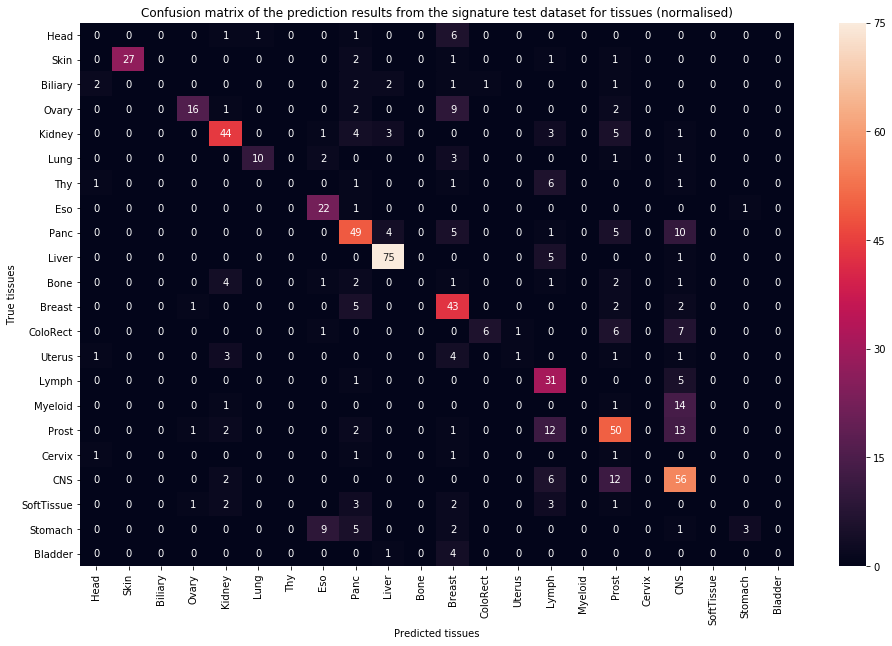

In [359]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the prediction results from the signature test dataset for tissues (normalised)")

plt.show()

## Validation

In [262]:
nonPCAWG_wgs_act.head()

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,ALL,PD4020a,0.995,208,3006,0,0,365,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALL,SJBALL011_D,0.905,66,0,0,0,144,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALL,SJBALL012_D,0.921,68,0,0,0,72,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALL,SJBALL020013_D1,0.971,226,0,0,0,70,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ALL,SJBALL020422_D1,0.937,104,0,0,0,247,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
PCAWG_wgs_act.head()

,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA,SP117655,0.968,1496,1296,0,0,1825,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA,SP117556,0.963,985,0,0,0,922,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biliary-AdenoCA,SP117627,0.973,1110,528,0,0,1453,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Biliary-AdenoCA,SP117775,0.987,1803,1271,0,0,2199,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Biliary-AdenoCA,SP117332,0.987,441,461,0,0,840,0,0,...,0,0,0,0,0,0,0,0,0,0


In [360]:
#Get the shared tissue types from the PCAWG and nonPCAWG activity data
PCAWGtissues = set(PCAWG_wgs_act["Cancer Types"].values)
nonPCAWGtissues = set(nonPCAWG_wgs_act["Cancer Types"].values)

PCAWGtissues = [type.split("-")[0] for type in PCAWGtissues]
print(PCAWGtissues)
print()
nonPCAWGtissues = [type.split("-")[0] for type in nonPCAWGtissues]
print(nonPCAWGtissues)

print()
actShared = []
for tissue in nonPCAWGtissues:
    if (tissue in PCAWGtissues):
        actShared.append(tissue)
print(actShared)

rowsToKeep = []
for i in range(61, len(nonPCAWG_wgs_act)):
    if nonPCAWG_wgs_act.iloc[61]["Cancer Types"].split("-")[0] in actShared:
        rowsToKeep.append(i)
        
nonPCAWG_wgs_actVal = nonPCAWG_wgs_act.iloc[rowsToKeep]

nonPCAWG_wgs_actVal.head(2)

['Breast', 'Eso', 'SoftTissue', 'Kidney', 'Liver', 'Prost', 'Lung', 'Breast', 'Myeloid', 'Head', 'CNS', 'CNS', 'Lymph', 'Cervix', 'Bladder', 'Stomach', 'Lymph', 'CNS', 'Skin', 'Uterus', 'Myeloid', 'Bone', 'Panc', 'ColoRect', 'Panc', 'Thy', 'Bone', 'Ovary', 'SoftTissue', 'Kidney', 'Lung', 'Bone', 'Biliary', 'Breast', 'Myeloid', 'Cervix', 'CNS']

['Panc', 'Blood', 'Bone', 'Liver', 'Eye', 'Lymph', 'CNS', 'CNS', 'Sarcoma', 'Ewings', 'AML', 'Lymph', 'Eso', 'Stomach', 'Sarcoma', 'Skin', 'ALL', 'Breast', 'Ovary', 'Lung', 'Panc', 'ColoRect', 'Biliary', 'Kidney', 'CNS', 'Prost', 'CNS']

['Panc', 'Bone', 'Liver', 'Lymph', 'CNS', 'CNS', 'Lymph', 'Eso', 'Stomach', 'Skin', 'Breast', 'Ovary', 'Lung', 'Panc', 'ColoRect', 'Biliary', 'Kidney', 'CNS', 'Prost', 'CNS']


,Cancer Types,Sample Names,Accuracy,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
61,Biliary-AdenoCa,CCA_CH_1,0.941,919,0,0,0,1943,0,0,...,0,0,0,0,0,0,0,0,0,0
62,Biliary-AdenoCa,CCA_CH_2,0.973,198,186,0,0,414,0,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
#Drop columns "Sample Names" and "Accuracy"
#Normalise the dataset so rows sum to 1
nonPCAWG_wgs_actValNorm = nonPCAWG_wgs_actVal.drop(["Sample Names", "Accuracy"], axis = 1)
for i in range(len(nonPCAWG_wgs_actValNorm)):
    nonPCAWG_wgs_actValNorm.iloc[i] = nonPCAWG_wgs_actValNorm.iloc[i][1:] / sum(nonPCAWG_wgs_actValNorm.iloc[i][1:])
nonPCAWG_wgs_actValNorm["Cancer Types"] = nonPCAWG_wgs_act["Cancer Types"]
tissues = [i.split("-")[0] for i in nonPCAWG_wgs_actValNorm["Cancer Types"]]
nonPCAWG_wgs_actValNorm["tissue"] = tissues

In [325]:
nonPCAWG_wgs_actValNorm.head(2)

,Cancer Types,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,tissue
61,Biliary-AdenoCa,0.057173,0.000000,0.0,0.0,0.120878,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary
62,Biliary-AdenoCa,0.131912,0.123917,0.0,0.0,0.275816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary


0.46840354767184034


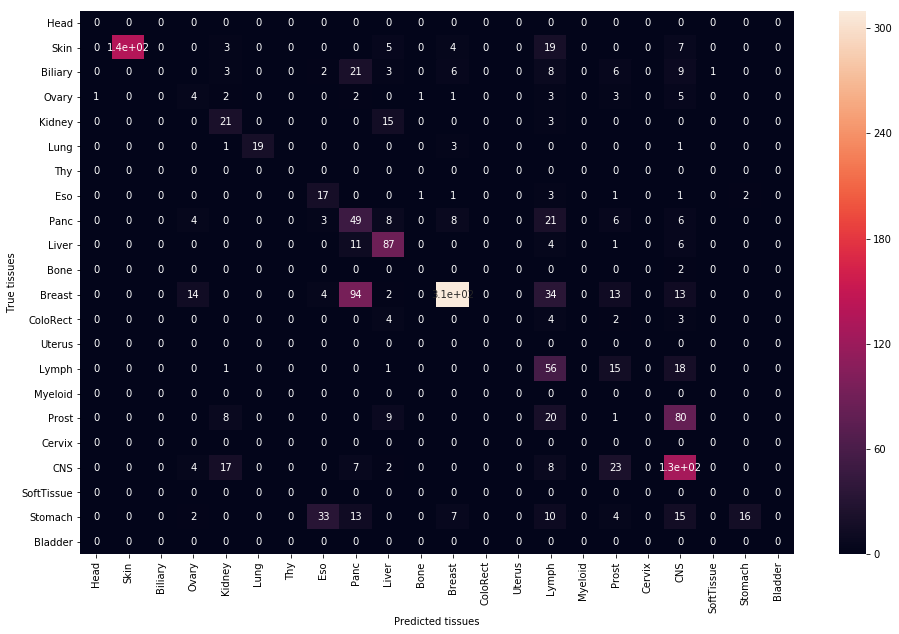

In [328]:
test_y = nonPCAWG_wgs_actValNorm["tissue"]
test_X = nonPCAWG_wgs_actValNorm.drop(["Cancer Types", "tissue"], axis = 1)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
plt.show()

# Random forest classifier for the combined mutational catalogue and signature activity data

In [403]:
#Combine the mutational and signature dataset
PCAWG_wgs_mutT = PCAWG_wgs_mut.T
PCAWG_wgs_mutT = PCAWG_wgs_mutT.drop(["Mutation type", "Trinucleotide"])
PCAWG_wgs_mutT["type"] = PCAWG_wgs_mutT.index.str.split("::").str[0]

PCAWG_wgs_mutT = PCAWG_wgs_mutT.reset_index()
merged = pd.concat([PCAWG_wgs_mutT, PCAWG_wgs_act.drop(["Cancer Types", "Sample Names", "Accuracy"], axis = 1)], axis = 1) 

In [364]:
merged.head(2)

,index,0,1,2,3,4,5,6,7,8,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
0,Biliary-AdenoCA::SP117655,269,148,25,154,215,148,27,180,165,...,0,0,0,0,0,0,0,0,0,0
1,Biliary-AdenoCA::SP117556,114,56,13,70,63,49,7,69,81,...,0,0,0,0,0,0,0,0,0,0


In [365]:
#Random forest classifier for the combined dataset of mutations and signatures (Not normalised)
y = merged['type'] #Labels
X = merged.drop(["index",'type'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7424460431654676


In [408]:
#Normalise the mutation&signature dataset

PCAWG_wgs_mutTCopy = PCAWG_wgs_mutT.copy(deep=True)
for i in range(len(PCAWG_wgs_mutT)):
    PCAWG_wgs_mutT.iloc[i] = PCAWG_wgs_mutT.iloc[i][1:97] / sum(PCAWG_wgs_mutT.iloc[i][1:97])

PCAWG_wgs_mutT["type"] = PCAWG_wgs_mutTCopy["type"]
PCAWG_wgs_mutT["index"] = PCAWG_wgs_mutTCopy["index"]

mergedNorm = pd.concat([PCAWG_wgs_mutT, PCAWG_wgs_actNorm], axis = 1) 

In [432]:
mergedNorm.head(2)

,index,0,1,2,3,4,5,6,7,8,...,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,tissue
0,Biliary-AdenoCA::SP117655,0.0180537,0.00993289,0.00167785,0.0103356,0.0144295,0.00993289,0.00181208,0.0120805,0.0110738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary
1,Biliary-AdenoCA::SP117556,0.0224057,0.0110063,0.00255503,0.0137579,0.0123821,0.0096305,0.00137579,0.0135613,0.0159198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary


In [450]:
#Random forest classifier for the combined dataset of mutations and signatures (normalised, cancer types)
y = mergedNorm['type'] #Labels
X = mergedNorm.drop(["index",'type', "tissue", 'Cancer Types'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7553956834532374


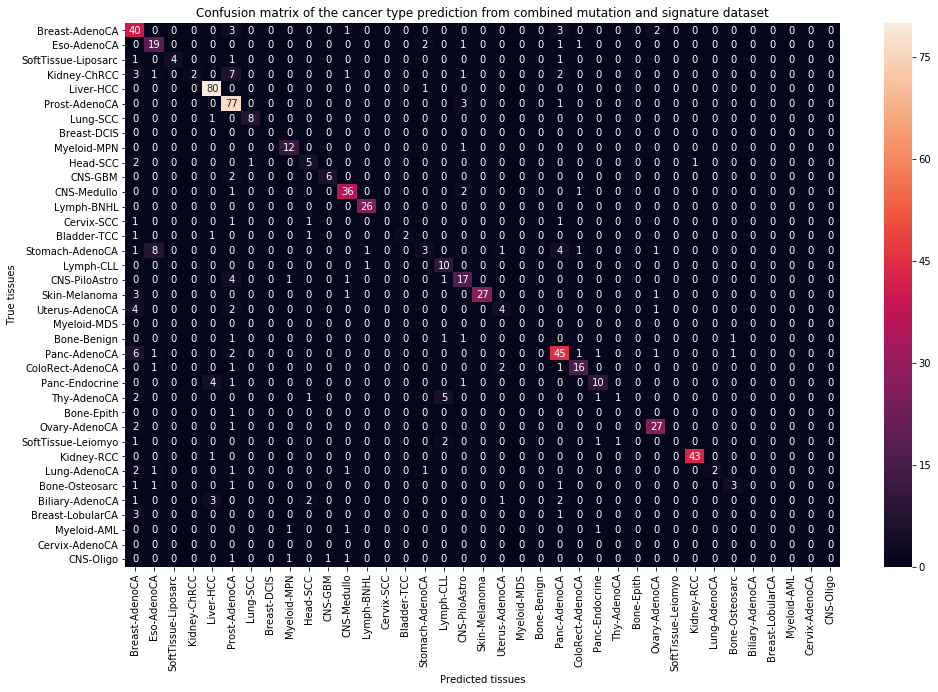

In [452]:
cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the cancer type prediction from combined mutation and signature dataset")

plt.show()

In [566]:
#Random forest classifier for the combined dataset of mutations and signatures (normalised, tissue types)
y = mergedNorm['tissue'] #Labels
X = mergedNorm.drop(["index",'type', "tissue", 'Cancer Types'], axis = 1) #Data
#split the dataset to train and test data, the library can do this automatically
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 12,
              'max_leaf_nodes': None}


RF_model = RandomForestClassifier(**parameters)
RF_model.fit(train_X, train_y)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)

0.7683453237410072


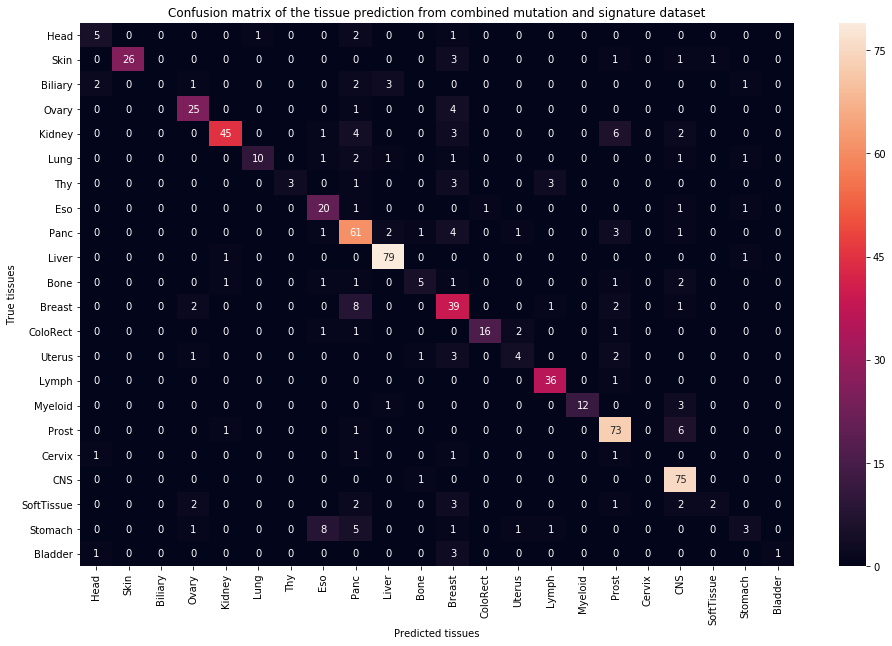

In [449]:
cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
ax.set_title("Confusion matrix of the tissue prediction from combined mutation and signature dataset")

plt.show()

## Validation

In [539]:
#Merge the nonPCAWG mutation and activity data (not normaliset)
nonPCAWG_wgs_mutT = nonPCAWG_wgs_mut.T
nonPCAWG_wgs_mutT = nonPCAWG_wgs_mutT.drop(["Mutation type", "Trinucleotide"])
nonPCAWG_wgs_mutT["type"] = nonPCAWG_wgs_mutT.index.str.split("::").str[0]

nonPCAWG_wgs_mutT = nonPCAWG_wgs_mutT.reset_index()
validationMerged = pd.concat([nonPCAWG_wgs_mutT.iloc[61:], nonPCAWG_wgs_act.iloc[61:].drop(["Cancer Types", "Sample Names", "Accuracy"], axis = 1)], axis = 1)
nonPCAWG_wgs_mutT = nonPCAWG_wgs_mutT.iloc[61:]

In [545]:
#Merge the normalised nonPCAWG mutation and activity data
nonPCAWG_wgs_mutTCopy = nonPCAWG_wgs_mutT.copy(deep=True)
for i in range(len(nonPCAWG_wgs_mutT)):
    nonPCAWG_wgs_mutT.iloc[i] = nonPCAWG_wgs_mutT.iloc[i][1:97] / sum(nonPCAWG_wgs_mutT.iloc[i][1:97])
nonPCAWG_wgs_mutT["type"] = nonPCAWG_wgs_mutTCopy["type"]
nonPCAWG_wgs_mutT["index"] = nonPCAWG_wgs_mutTCopy["index"]


nonPCAWG_wgs_actVal = nonPCAWG_wgs_act.iloc[61:]
nonPCAWG_wgs_actVal = nonPCAWG_wgs_actVal.drop(["Sample Names", "Accuracy"], axis = 1)
tissues = [i.split("-")[0] for i in nonPCAWG_wgs_actVal["Cancer Types"]]
for i in range(len(nonPCAWG_wgs_actVal)):
    nonPCAWG_wgs_actVal.iloc[i] = nonPCAWG_wgs_actVal.iloc[i][1:] / sum(nonPCAWG_wgs_actVal.iloc[i][1:])
nonPCAWG_wgs_actVal["Cancer Types"] = nonPCAWG_wgs_actVal["Cancer Types"]
nonPCAWG_wgs_actVal["tissue"] = tissues
nonPCAWG_wgs_actVal = nonPCAWG_wgs_actVal.drop(["Cancer Types"], axis = 1)

validationNormMerged = pd.concat([nonPCAWG_wgs_mutT, nonPCAWG_wgs_actVal], axis = 1)

In [547]:
nonPCAWG_wgs_mutT.head(2)

,index,0,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,type
61,Biliary-AdenoCa::CCA_CH_1,0.0183526,0.0170462,0.00143088,0.0183526,0.0176061,0.012318,0.00149309,0.0201568,0.0194102,...,0.0273734,0.00298619,0.00236407,0.00286176,0.0101406,0.0117581,0.00653229,0.00647008,0.0164863,Biliary-AdenoCa
62,Biliary-AdenoCa::CCA_CH_2,0.0193205,0.00932712,0.00199867,0.0159893,0.00999334,0.00666223,0.00133245,0.0146569,0.00932712,...,0.00466356,0.00199867,0.00199867,0.00199867,0.00666223,0.00133245,0.00199867,0.00133245,0.0106596,Biliary-AdenoCa


In [548]:
nonPCAWG_wgs_actVal.head(2)

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,tissue
61,0.057173,0.000000,0.0,0.0,0.120878,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary
62,0.131912,0.123917,0.0,0.0,0.275816,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary


In [563]:
validationNormMerged

(1804, 164)

In [565]:
#validationNormMerged = pd.concat([nonPCAWG_wgs_mutT, nonPCAWG_wgs_actVal], axis = 1)
validationNormMerged.head(2)

,index,0,1,2,3,4,5,6,7,8,...,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60,tissue
61,Biliary-AdenoCa::CCA_CH_1,0.0183526,0.0170462,0.00143088,0.0183526,0.0176061,0.012318,0.00149309,0.0201568,0.0194102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary
62,Biliary-AdenoCa::CCA_CH_2,0.0193205,0.00932712,0.00199867,0.0159893,0.00999334,0.00666223,0.00133245,0.0146569,0.00932712,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Biliary


0.5698447893569845


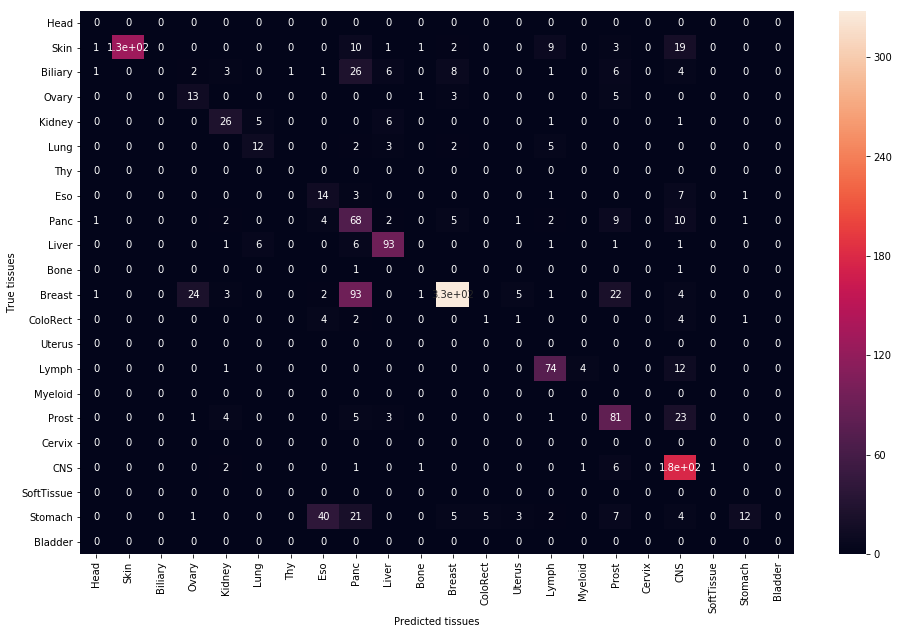

In [567]:
test_y = validationNormMerged["tissue"]
test_X = validationNormMerged.drop(["type", "tissue", "index"], axis = 1)

RF_predictions = RF_model.predict(test_X)
score = accuracy_score(test_y ,RF_predictions)
print(score)


cancer_type = list(set(y))
cm = np.array(confusion_matrix(test_y, RF_predictions, labels=cancer_type))
confusion = pd.DataFrame(cm, index=cancer_type, columns=cancer_type)

fig, ax = plt.subplots(figsize = (16,10))
ax = sns.heatmap(confusion, annot=True)
ax.set_ylabel("True tissues")
ax.set_xlabel("Predicted tissues")
plt.show()